# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "nicolas"
ln1 = "saint"
fn2 = "matthis"
ln2 = "guerin"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_saint_nicolas_and_guerin_matthis.ipynb


In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [ ]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

<ipython-input-3-d251d738d957>:4: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [ ]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j] * (old_w_j - w[j])
        # END TODO

        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)

    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date

    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        # TODO
        # choose feature j to update:
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient -= gram[:, j] * (old_w_j - w[j])
        # END TODO

        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)

    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [ ]:
# Computing fmin_l_bfgs_b as our solver

from scipy.optimize import fmin_l_bfgs_b

def loss(w):
    return norm(A.dot(w) - b) ** 2 / 2.

def grad(w):
    return A.T.dot(A.dot(w) - b)

w_min, f_min, _ = fmin_l_bfgs_b(loss, np.zeros(n_features), grad, pgtol=1e-30, factr=1e-30)


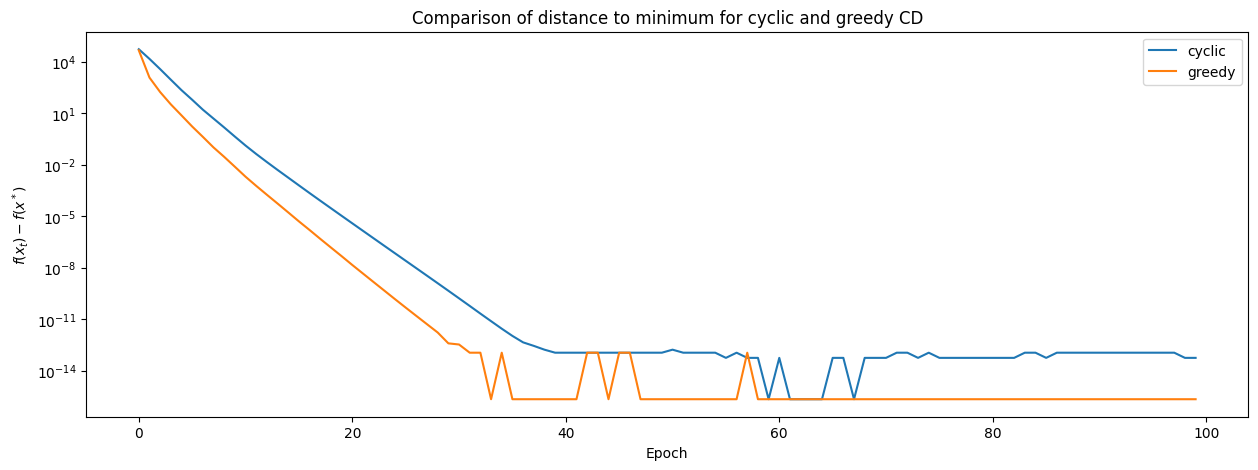

In [ ]:
n_iter = 10000
all_objs = {}
w = {}
eps = np.finfo('float').eps

# Run coordinate descent methods
for name, method in [("cyclic", cyclic_cd), ("greedy", greedy_cd)]:
    w[name], all_objs[name] = method(A, b, n_iter)

# Plotting
plt.figure(figsize=(15, 5))
for name in all_objs:
    plt.semilogy(np.maximum(all_objs[name] - f_min,eps), label=name)

plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel('$f(x_t) - f(x^*)$')
plt.title("Comparison of distance to minimum for cyclic and greedy CD")

plt.show()

**Compare the performance of cyclic and greedy CD as function of iterations.**

By setting n_iter=10000, we executed both algorithms and visually compared their performance in reaching the true minimum $f_{min}$.

In the case of 100 features, it is observed that the cyclic algorithm takes more time to approach a value close to the true minimum compared to the greedy algorithm. This is somewhat unexpected since, in theory, a greedy algorithm should perform worse than the cyclic algorithm. However, this anomaly can be easily explained by the relatively small number of features.

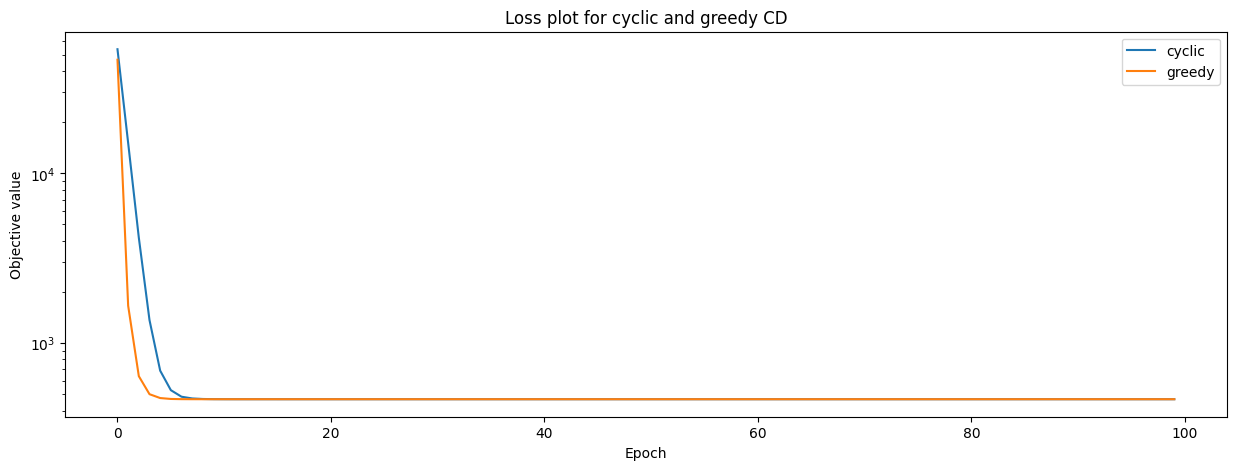

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))
for name in all_objs:
    plt.semilogy(all_objs[name], label=name)

plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Objective value")
plt.title("Loss plot for cyclic and greedy CD")

plt.show()

This plot showing the comparison of both losses corroborates with our previous interpretation. The loss of the greedy algorithm decreases faster than for the cyclic CD.


**From a practical point of view, could you use greedy CD for L2 regularized logistic regression to solve OLS ?**

- No, using greedy coordinate descent for L2 regularized logistic regression won't solve Ordinary Least Squares (OLS) directly. Logistic regression and OLS are different problems with distinct loss functions and formulations. Greedy CD for logistic regression addresses classification tasks, while OLS requires techniques specific to linear regression and the squared loss function.

**But with 100,000 features?**

- CD is generally more suitable for L1 regularization (Lasso) due to its ability to induce sparsity. For L2 regularized logistic regression with a large number of features like 100 000, CD may not be the most efficient choice because it would take a huge computational time to process due to the fact that have to compute all the gradient. SGD or mini-batch gradient descent woule be a better choice.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) =
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0,
         \\ & [-1, 1] &\mathrm{otherwise.}
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*

We computed the subdifferential applied in 0 :

$$\partial f(0)=-\frac{1}{2}\left\{x^{\top} y\right\}+\partial\|\cdot\|_1\left(0_p\right)$$

Therefore :

$$\boxed{0 \in\partial f(0)}$$

And according to the Fermat's Rules, if $f$ is a convex function, then $0 \in\partial f(0)$.

Proof of convextiy :

We Know that $\|\cdot\|_1$ is convex.
We compute the Hessian :

$$H=\sum_{i=1}^n \frac{y_i^2 x_i^{\top} x_i e^{\left(y_i \omega^{\top} x_i\right)}}{\left(1+e^\left(y_i \omega^{\top} x_i\right)\right)^2}$$

More over, for $b\in\mathbb{R}^n$ :
$$b^{\top} x_i x_i^{\top} b=\left\|x_i{ }^{\top} b\right\|^2 \geqslant 0$$

Therefore :
$$H\geqslant0$$
Conclusion, by the uniqueness :  

$$\underline{f\ is\ convex\ and\ \hat{w}=0}$$.

PROOF OF THE EQUIVALENCE :

We can whrite $F$, $R$, $Y$ and $X$ such that:

* $F(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$,
* $T(w) = \| w \|_1$,
* $Y \in \mathbb{R}^n$,
* $X \in \mathbb{R}^p$.
    
we have:

$$\hat{w} \in \arg \min_w \big(F(w)  + \lambda T(w) \big)$$

with:
    
$$\partial\big(F(\hat{w} + \lambda T(\hat{w}) \big) = \nabla F(\hat{w}) + \lambda \nabla T(\hat{w})$$

Assuming the uniqueness of the solution we can whrite ($\hat{w} = 0_p$), so we have :

$$
\begin{align*}
0 \in \partial\big(F(\hat{w} + \lambda T(\hat{w}) \big) &\iff 0 \in \nabla F(\hat{w}) + \lambda \partial T(\hat{w}) \\
& \iff -\nabla F(\hat{w})\in \lambda \partial T(\hat{w}) \\
& \iff -\nabla F(0_p)\in \lambda \partial T(0_p)
\end{align*}
$$
With the Hint:

$$
\lambda \partial R(\hat{w}) = \lambda \partial\|0_p\|_1 = \lambda \partial |0| \times \ldots \times \partial |0| = \lambda [-1,1]^p = [-\lambda, \lambda ]
$$

More over :
\begin{align*}\
\nabla F(\hat{w})=-\sum_{i=1}^n y_i \times \frac{e^{-y_i \omega^{\top} x_i}}{1+e^{-y_i \omega^{\top} x_i}} x_i
\end{align*}


If we denote denote $\sigma(x) = \dfrac{1}{1+\mathrm{e}^{-x}}$ for simplification, and with the assumption : $\hat{w} = 0_p$

$$
\begin{align*}
\nabla F(0_p)&= \Big(Y\odot \big(\sigma(0_p)-1\big)\Big)^\top X \\  
&= -\dfrac{1}{2} Y^\top X \\
&= -\dfrac{1}{2} X^\top Y
\end{align*}
$$

Now we can whrite:

$$
\begin{align*}
-\nabla F(0_p)\in \lambda \partial R(0_p) &\iff \dfrac{1}{2} X^\top Y \in [-\lambda, \lambda ]^p \\
& \iff \forall\ i, \left|\left[\dfrac{1}{2} X^\top Y\right]_i\right| \leq \lambda \\
& \iff  \max_i \left|\left[\dfrac{1}{2} X^\top Y\right]_i\right| \leq \lambda \\
& \iff  \left\| \dfrac{1}{2} X^\top Y\right\|_{\infty} \leq \lambda
\end{align*}
$$

We show that:
$$\boxed{\lambda_{max}\leq \lambda \iff \hat w = 0_p}$$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

*answer here*

By theorem, we know that a twice-differentiable function which is L-smooth is bounded by $L$:

$$\text{F is L-Smooth and twice-differentiable}\iff \|\nabla^2F(w)\|_2 \leq L$$

So, let's compute the second derivatives :

We will denote $\sigma(x) = \dfrac{1}{1+\mathrm{e}^{-x}}$ for simplification.

$$
\begin{align*}
\dfrac{\partial^2}{\partial w_j^2} F(w_j) &= \sum_{i=1}^n\dfrac{\partial^2}{\partial w_j^2}\log \big( 1 + e^{- y_i w^\top x_i} \big) \\
                                        &= \sum_{i=1}^n \dfrac{\partial}{\partial w_j} \Big(-y_i x_{i,j}\big(\sigma(- y_i w^\top x_{i}) \big) \Big) \\
                                        &= \sum_{i=1}^n (-y_i x_{i,j})^2\sigma'(y_i w^\top x_{i})
\end{align*}$$

We know that, $\sigma'(x) = \sigma(x)\big(1-\sigma(x)\big) \leq \dfrac{1}{4}$ . \\
More over for logistic regression, we have $y_i \in \left\{-1, +1\right\} $ and $y_i^2 = 1$.

$$ \begin{align*}
\dfrac{\partial^2}{\partial w_j^2} F(w_j)
&\leq \dfrac{1}{4} \sum_{i=1}^n (y_i x_{i,j})^2   \qquad \qquad \\
&\leq \dfrac{1}{4} \sum_{i=1}^n x^2_{i,j} \qquad \qquad  \\
&\leq \dfrac{1}{4} \|X_j\|_2^2 \qquad \qquad \text{with } X_j \in \mathbb{R}^p
\end{align*}
$$



    
So we show :

$$\boxed{\gamma_j = L_j = \dfrac{1}{4} \|X_j\|_2^2}$$

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [ ]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.
# much easier to parametrize lambda as a function of lambda_max than
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)

    # TODO
    lips_const = [norm(X[:,i] , ord=2)**2 / 4 for i in range(n_features)]
    # END TODO

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -sum([y[i] * X[i,j] * sigmoid(-y[i]*Xw[i]) for i in range(n_samples)])
            w[j] = soft_thresh(old_w_j - grad_j/lips_const[j], lamb/lips_const[j])

            if old_w_j != w[j]:
              Xw += w[j] * X[:,j] - old_w_j * X[:,j]
            #END TODO

        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)

    return w, all_objs

In [ ]:
w, loss_values = cd_logreg(X, y, lamb, n_iter=10)


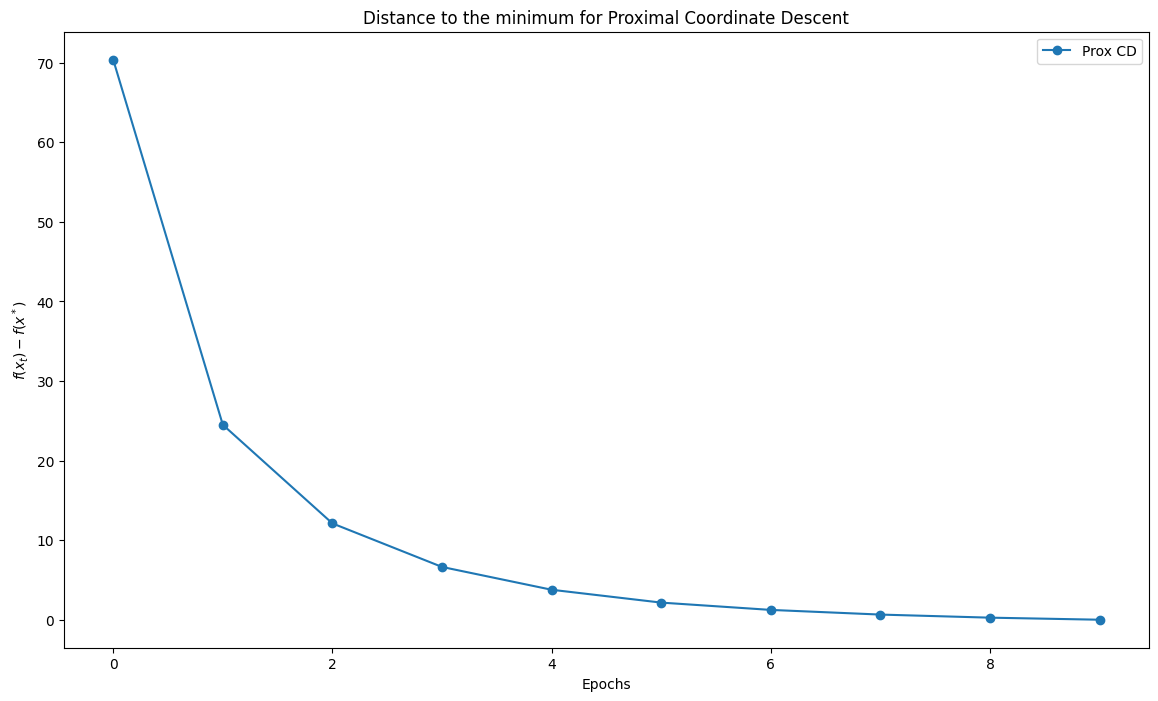

In [ ]:
# Calculate the distances to the minimum
distances_to_minimum = [norm(a - loss_values[-1]) for a in loss_values]

# Plot the distances
plt.figure(figsize=(14, 8))
plt.plot(distances_to_minimum, 'o-', label="Prox CD")

plt.title('Distance to the minimum for Proximal Coordinate Descent')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()

We can see that our cyclic proximal coordinate descent for sparse Logistic regression converges toward a minimum fast. Let's compare it now with real data with ISTA algorithm.


# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [ ]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name leukemia exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [ ]:
def prox_L1(x, lmbd):
    return np.sign(x)*np.maximum(np.abs(x)-lmbd, 0)

def L1_norm(x, lmbd):
    return lmbd*np.sum(np.abs(x))

def loss_logreg(x):
    n = X.shape[0]
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i],x))) for i in range(n)])

def grad_logreg(x):
    return -sum([y[i] * X[i,:] * sigmoid(-y[i]*X[i].dot(x)) for i in range(X.shape[0])])

def smoothness_const_loreg(A):
    L = 1/4*(np.linalg.norm(A,2)**2)
    return L

def proximal_gradient_descent(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50):
    x = x0.copy()
    objectives = [f(x) + R(x, lmbd)]

    for k in range(1, n_iter + 1):
        x = prox_R(x - step * grad_f(x), lmbd * step)
        obj = f(x) + R(x, lmbd)
        objectives.append(obj)

    return x, objectives


In [ ]:
# ISTA results
n_iter = 10
x0_ista = np.zeros(X.shape[1])
step_size_ista = 1 / smoothness_const_loreg(X)
w_min_ista, obj_ista = proximal_gradient_descent(x0_ista, loss_logreg, grad_logreg, L1_norm, prox_L1,
                                                 step_size_ista, lmbd=lambd, n_iter=n_iter * X.shape[1])

In [ ]:

# Proximal coordinate descent results
w_prox_cd, obj_prox_cd = cd_logreg(X, y, lambd, n_iter)

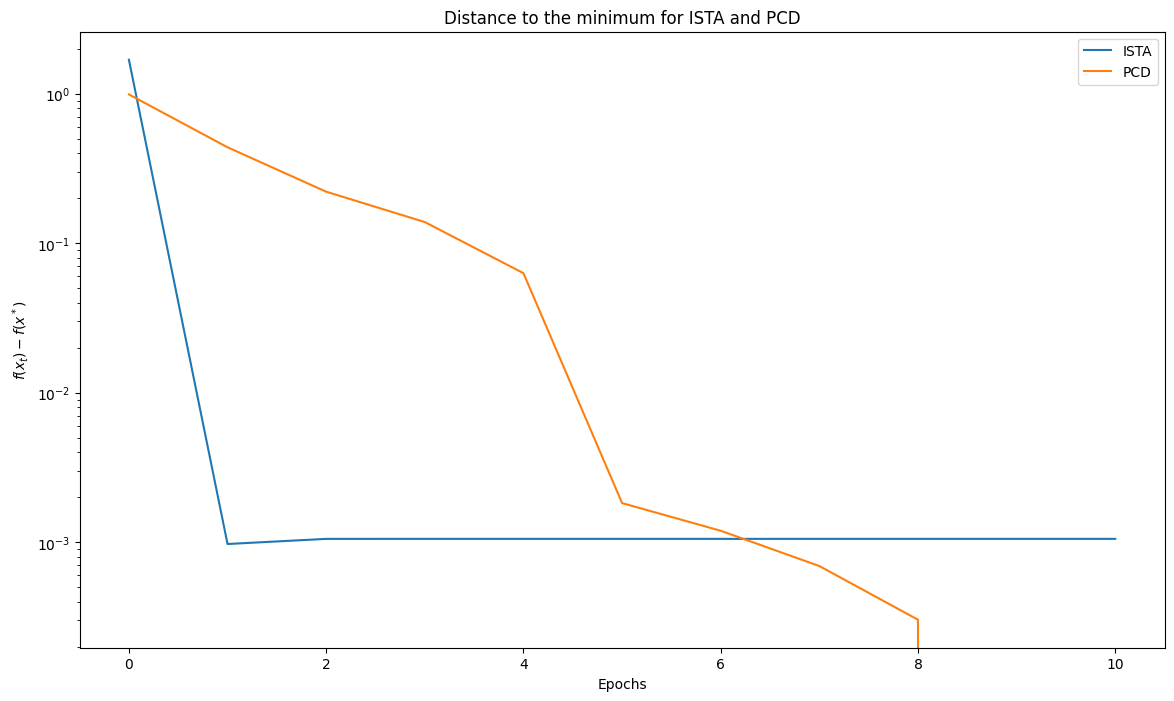

In [ ]:
prox_obj = [norm(obj-obj_prox_cd[-1] ) for obj in obj_prox_cd]
ista_obj = [norm(obj-obj_prox_cd[-1] ) for obj in obj_ista[::n_feature]]

plt.figure(figsize=(14,8))
plt.semilogy(ista_obj, label="ISTA")
plt.semilogy(prox_obj ,label="PCD")
plt.title('Distance to the minimum for ISTA and PCD')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()

**Comparaison between Ista and PCD :**

As we see on the graph, ISTA converge at speed $10^3$ and stabilize around $10^{-3}$.

For the Proximal Gradient Descent the convergence is more long than ISTA but the minimun find is better than ISTA. We see the result of $\|f(x_t)-f(x^*)\|$ is around $10^{-4}$

Its will be interesting to see if FISTA Algo converge even faster than ISTA on this dataset.